This notebook describes the step by step code for the implementation of the adjoint method outlined by Andrew M. Bradley in this [pdf](https://cs.stanford.edu/~ambrad/adjoint_tutorial.pdf) using the 'simple example' from the pdf.

Because the pdf is concise and therefore dense, it can be quite hard to understand all the points of the adjoint method. I recommend looking at the youtube channel Machine Learning & Simulation and his topic on the adjoint method [playlist](https://www.youtube.com/playlist?list=PLISXH-iEM4Jk27AmSvISooRRKH4WtlWKP). The PDF by Dr. Bradley is more general and applies to Differential Algebraic Equations (DAEs) while the YouTube videos is the adjoint method focused on Explicit system of ODEs. Generally, we work with the latter type of ODEs

This Notebook was done to help me learn about the adjoint method as well as bridge the gap between these two sources of information. This notebook focuses on the implementation and not the reasons for each step.

# Simple Example

We wish to solve the Optimisation problem:      
$$
\min \int_0^T x\;\mathrm{d}t \\
 \\
\begin{aligned}
\mathrm{s.t}\quad \dot{x}= bx \\
x(0) - a =0 
\end{aligned}
$$

WE can think of this as finding the function x(t) that gives the smallest area given the ODE by changing the parameters a and b


Here the analytical solution of this ODE is : $ x(t) = ae^{bt}$ so our challenge is to find the combination of a and b such that the area under  $ x(t) = ae^{bt}$ is minimized.

Note that all stages of this method has an analytical method so you can check the results if you want to try this on your own.

We'll define the following:
- x : vector of state variables (can also be sometimes called y or u)
- t : independent variable (usually time) 
- p : vector representing all parameters
- f : scalar objective function
- g : is the relationship between the the state and parameters e.g. initial conditions
- h : is the ODE in implicit form

So from the problem above we define the following
$$
\begin{align}
f(x,t;p) &= x \\
p &= [a,b]^T \\
g(x(t = 0),p) &= x(0) - a \\
h(x,\dot{x},p,t) &= \dot{x} - bx \\
t &\in [0,T]
\end{align}
$$


In [4]:
# import numpy as np
import jax
import jax.numpy as jnp
# from scipy.integrate import odeint
from jax.experimental.ode import odeint
# from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from jax.scipy.integrate import trapezoid

In [360]:

#Define Parameters
a = 1.
b = -2.
p = jnp.array([a,b])


# Initial Condition
x0 = jnp.array([a])

#Define ODE
def dydt(x,t,p):
    a,b = p
    return b*x


#Define functions
f = lambda x,t,p = [0,0] : x
g = lambda x0,p : x0 - p[0]
h = lambda x,x_dot,t,p : x_dot - dydt(x,t,p[1])


## Step 1 Solve ODE

First we integrate the ODE forward in time. This can be accomplished using ODEint. No need to reinvent the wheel. With this simple example we have the analytic solution of the ODE:
$$
x(t) = ae^{bt}
$$



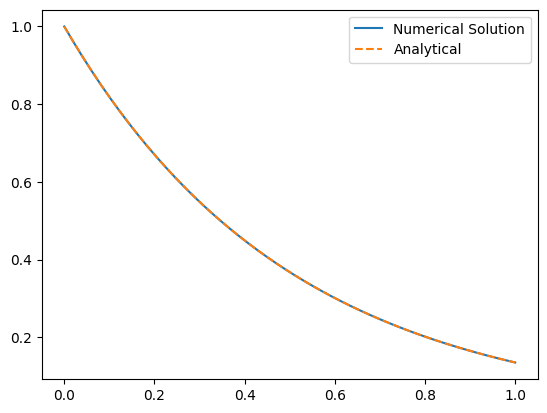

In [363]:
t= jnp.linspace(0,1,50)
sol = odeint(dydt,x0,t,p)
plt.plot(t,sol,label = 'Numerical Solution')
plt.plot(t,a*jnp.exp(b*t),linestyle = '--',label = 'Analytical')
plt.legend()

We will also need to call this ODE solution for the next step. ODEint however returns an $N_t \times N_x$ array of solutions where $N_t$ is the number of time points recoded by odeint and $N_x$ is the number of state variables in the system (For this example only one state variable)

In [364]:
# Jax doesn't have a nice interp1D function that scipy has so well have to wrap it
def jax_interp1D(t_array,sol_array,col = 0):
    #Time array is shape(N_t) while sol array has extra dimension of (N_t,N_x) so need to specify the col/state variable we want to interpolate
    def inner_func(t):
        
        x = jnp.interp(t,xp = t_array,fp = sol_array[:,col])
        if isinstance(t,(float,int)):
            return x[jnp.newaxis]
        return x
    return inner_func

#This interpolates the solution x for some t in [0,1]
x = jax_interp1D(t,sol,col = 0)
x(1).shape

(1,)

## Step 2 Solve Adjoint Method

All the maths results in us trying to find the adjoint variables $\lambda$ which has the same size as the state vector x. We need to solve the following ODE backwards in time:

$$
\partial_{\dot{x}}h^T\dot{\lambda} = \partial_xf + (\partial_xh - \mathrm{d}_t\partial_{\dot{x}}h)^T\lambda 
$$

Using an auto diff package such as jax, all these partial derivatives terms are actually very easy to compute. Furthermore, generally the ODEs we are solving can be expressed in explicit form  e.g. $\dot{y} = f(y,t)$ and so the $\partial_{\dot{x}} h = 1$ amd so the adjoint ODE reduces to:

$$
\dot{\lambda} = \partial_xf + (\partial_xh)^T\lambda \\
\lambda(t=T) = 0
$$

Recall:
$$
\begin{align}
f(x,t) = x &\implies \partial_xf = 1 \\ 
h = \dot{x} - bx &\implies \partial_xh = -b
\end{align}
$$

here we use the jax jacobian to automatically calculate these gradients for us. This is very handy as it does not require us to explcitely define the gradient. Note that in general, the derivatives are also functions of time and state

In [418]:
#Readding it here so you dont have to remember
f = lambda x,t,p = [0,0] : x
h = lambda x,x_dot,t,p : x_dot - dydt(x,t,p)

del_f_del_x = jax.jacobian(f)
del_h_del_x = jax.jacobian(h)

#Terminal Condition
adjoint_T = jnp.array([0.])

# del_h_del_x(1.,0,0,p)

def adjoint_ODE(adjoint,t):
    return del_f_del_x(x(t),t,p).T + del_h_del_x(x(t),0.,t,p).T*adjoint



A key point in the adjoint method is to we are solving this ODE backwards in time starting from T and then going backwards to 0. ODEint typically only allows time stepping forward in time. We need to conver our Terminal value problem into a initial value problem for the solver:

 If we want to go backwards in time then we can instead solve the ODE: 
$$\dfrac{dy}{dt} = -f(y,-t)$$

The solution of the adjoint has the following analytical solution:

$$
\lambda(t) = \dfrac{1}{b}(1-e^{b(T-t)})
$$

Note that as we have solved the adjoint backwards in time, when plotting or calling the function we need to reverse the order of the outputs (A good check is to make sure the adjoint value at time T is zero)

[[-1.]]


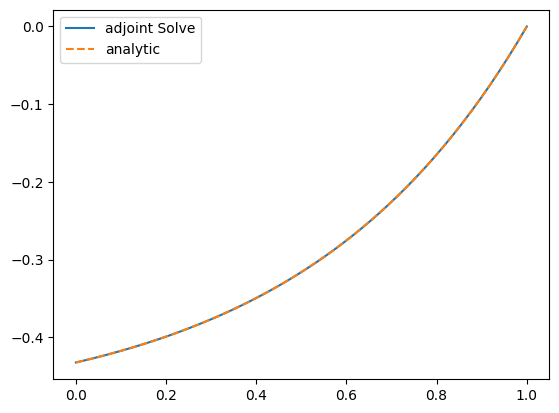

In [419]:
#Modify the function as we are stepping back in time
adjoint_tau = lambda adjoint,t : -adjoint_ODE(adjoint,-t)

T=1
tau= t

print(adjoint_tau(adjoint_T,2))
adjoint_sol = odeint(adjoint_tau,adjoint_T,tau)

# adjoint_tau(adjoint_0,1.)
plt.plot(tau,adjoint_sol[::-1],label = 'adjoint Solve')

analytic_adjoint = 1/b*(1-jnp.exp(b*(T-t)))
plt.plot(tau,analytic_adjoint,linestyle = '--',label = 'analytic')

plt.legend()

## Step 3  Solve Sensitivity of F Almost There! 

Now that we have the adjoint we can calculate the senstivity of F w.r.t the parameters p we need to solve the following equation:

$$
\dfrac{dF}{dp} = (\lambda^T\ \partial_{\dot{x}}h)|_{t=0}\ \partial_{x}g^{-1}|_{t=0}\ g_p + \int_0^T (\partial_pf+\lambda^T\partial_ph) \   \mathrm{d}t
$$

### First Term

The first variable is the adjoint vector $\lambda$ evaluated at $t=0$ we obtained this in the second step

Recall that if the ODE is explicitly represented then $\partial_{\dot{x}}h(t=0) = 1$ so we can ignore this term for now.

g is a vector function of size $\R^{N_x}$ so the derivative is a matrix os size $\R^{N_x} \times \R^{N_x}$. The $\partial_{x}g^{-1}$ term looks scary as it has an inverse however, for most g we face, this partial derivative we will be 1 or the identity matrix of size $\R^{N_x} \times \R^{N_x}$. Furthermore, if we have to evaluate this term, note that the inverse only has to be computed once.

the $\partial_pg$ term is quite straigt forward to calculate
$$
g(x(0),p) = x(0) - a\\
$$
$$
\partial_pg = 
\begin{bmatrix}
\partial_ag & \partial_bg
\end{bmatrix}
= 
\begin{bmatrix}
-1 & 0
\end{bmatrix}
$$


In [369]:
adjoint_func = jax_interp1D(tau,adjoint_sol[::-1],col = 0)

adjoint_0 = adjoint_func(t=0)
del_g_del_p = jax.jacobian(g,1)
Step3_first_term = adjoint_0.T*del_g_del_p(0,jnp.array([a,b]))
# step_3_first_term = adjoint_0*del_g_del_p(0,jnp.array([a,b]))

### Second Integral Term
$$
\int_0^T (\partial_pf+\lambda^T\partial_ph) \   \mathrm{d}t
$$
For the definite integral, all of these gradients and variables can be evaluated at any state and time. This means we can easily calculate the integral between 0 and T using standard methods like trapezoid, Simpsons or quaderature rules.

Once weve calculated everything, we add everything together to get the sensitiviy of F wrt a and b. We can also compare with the analytic solution:

$$
\dfrac{dF}{dp} = 
\begin{bmatrix}
b^{-1}(-1+e^{bT})\\
\dfrac{a}{b}Te^{bT} - \dfrac{a}{b^2}(e^{bT} -1)
\end{bmatrix}
$$

In [371]:

tp = jnp.linspace(0,1,50)
# tp = jnp.array([0])

del_h_del_p = jax.jacobian(h,3)
del_f_del_p = jax.jacobian(f,2)

#This is ugly if you know a better way of doing this let me know!
def integrand_single_point(t):
    #Calculates the integrand at a single point t
    return del_f_del_p(x(t),t,p) + adjoint_func(t).T*del_h_del_p(x(t),0,t,p)
integrand = jax.vmap(integrand_single_point)


#Integrate term
integral = trapezoid(y = integrand(tp), x = tp ,axis = 0)
integral.shape
dF = Step3_first_term + integral
dF
# .T@del_h_del_p(xp,0,tp,p)
# adjoint_func(tp)[:,jnp.newaxis].T @ del_h_del_p(xp,0,tp,p)


Array([0.43233237, 0.14852852], dtype=float32)

In [372]:
def dF_analytic(p,T = 1):
    a,b = p
    return jnp.array([1/b*(jnp.exp(b*T)-1), a/b*T*jnp.exp(b*T)-a/b**2*(jnp.exp(b*T) - 1)])

dF_analytic([a,b],T = t[-1])

Array([0.43233237, 0.14849854], dtype=float32)

## Step 4 Updating our parameters

Now that we have our sensitivity, we can update our parameters using gradient descent. The next ith parameter should be:
$$
p_{i+1} = p_{i} - \gamma\dfrac{dF}{dp}
$$
Where $\gamma$ is an arbitary step size 

And then we repeat the process!

### Putting it all together now

In [5]:
#Lets rewrite the variables and parameters

#Define Parameters
a = 1.
b = -2.
p = jnp.array([a,b])
T = 1.

# Initial Condition
x0 = jnp.array([a])
#Terminal Condition for Adjoint
adjoint_T = jnp.array([0.])


#Define ODE
def dydt(x,t,p):
    a,b = p
    return b*x


#Define functions
f = lambda x,t,p = [0,0] : x
g = lambda x0,p : x0 - p[0]
h = lambda x,x_dot,t,p : x_dot - dydt(x,t,p)

#Jacobians

## Step 2
del_f_del_x = jax.jacobian(f)
del_h_del_x = jax.jacobian(h)

## Step 3
del_h_del_p = jax.jacobian(h,3)
del_f_del_p = jax.jacobian(f,2)
del_g_del_p = jax.jacobian(g,1)

#Other Functions

# Jax doesn't have a nice interp1D function that scipy has so well have to wrap it
def jax_interp1D(t_array,sol_array,col = 0):
    #Time array is shape(N_t) while sol array has extra dimension of (N_t,N_x) so need to specify the col/state variable we want to interpolate
    def inner_func(t):
        
        x = jnp.interp(t,xp = t_array,fp = sol_array[:,col])
        if isinstance(t,(float,int)):
            return x[jnp.newaxis]
        return x
    return inner_func


def adjoint_ODE(adjoint,t):
    return del_f_del_x(x(t),t,p).T + del_h_del_x(x(t),0.,t,p).T*adjoint

#Solve adjoint Method Backwards in time
adjoint_tau = lambda adjoint,t : -adjoint_ODE(adjoint,-t)

# For Step 3
#This is ugly if you know a better way of doing this let me know!
def integrand_single_point(t):
    #Calculates the integrand at a single point t
    return del_f_del_p(x(t),t,p) + adjoint_func(t).T*del_h_del_p(x(t),0,t,p)
integrand = jax.vmap(integrand_single_point)



In [6]:
#Store Results
x_list = []
objs = []
ps = []

num_iters = 20
gamma = 5


t = jnp.linspace(0,T,50)
for _ in range(num_iters):
    #Step 1 Solve ODE
    x = jax_interp1D(t,odeint(dydt,x0,t,p),col=0)
    x_list.append(x(t))

    #intermediate Step - Calc objective function
    obj = trapezoid(y = x(t), x = t)
    objs.append(obj)
    ps.append(p)
    #Step 2 Solve Adjoint
    adjoint_func = jax_interp1D(t,odeint(adjoint_tau,adjoint_T,t)[::-1],col=0)

    #Step 3 get dF
    adjoint_0 = adjoint_func(t=0)
    Step3_first_term = adjoint_0.T*del_g_del_p(0,p)
    Step3_integral = trapezoid(y = integrand(t), x = t ,axis = 0)
    dF = Step3_first_term + Step3_integral

    #Parameter Update
    p = p - gamma*dF
    # print(p)



## Data Visulisation

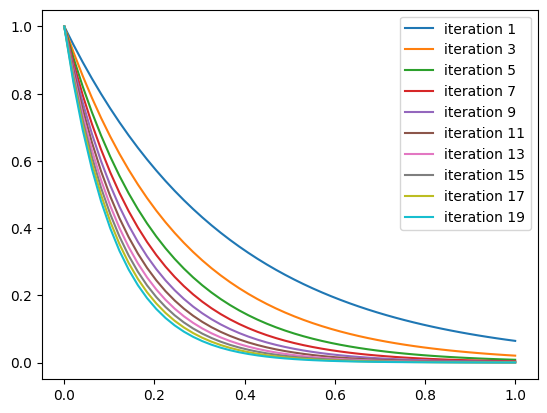

In [7]:
# Plot how the ODE changes
for i,x_d in enumerate(x_list):
    if i % 2:
        plt.plot(t,x_d,label = f'iteration {i}')
plt.legend()

Text(0, 0.5, 'Objective Function')

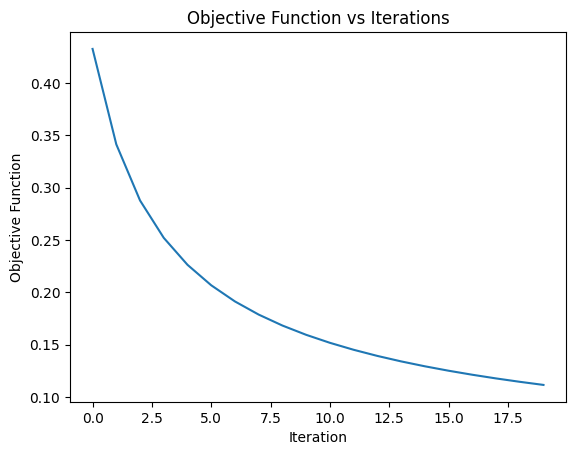

In [8]:
#Plot Objective Function vs Iteration
iters = list(range(num_iters))

plt.plot(iters,objs)
plt.title('Objective Function vs Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Function')

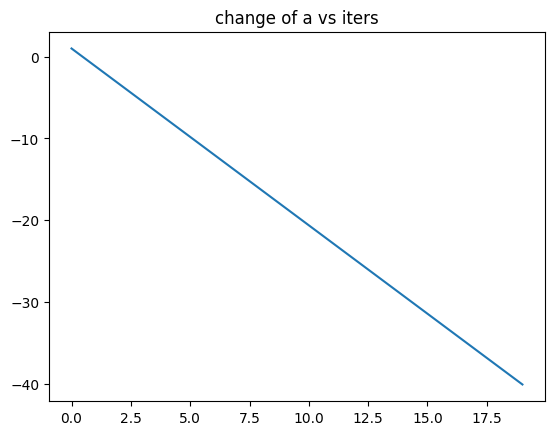

Text(0.5, 1.0, 'change of b vs iters')

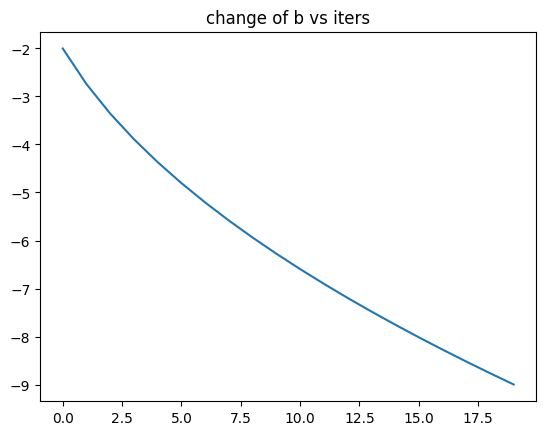

In [11]:
a_s,b_s = zip(*ps)
plt.plot(iters,a_s)
plt.title('change of a vs iters')
plt.show()
plt.plot(iters,b_s)
plt.title('change of b vs iters')